Importing is the dataset is with Ben's code:

In [2]:
# Import libraries
import os
import random
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image

# Set seed for reproducibility
random.seed(42)
data_dir = pathlib.Path('/Users/oulinyu/Desktop/DL/Project/data/')

In [6]:
# Original dataset
train_set_orig = torchvision.datasets.ImageFolder('/Users/oulinyu/Desktop/DL/Project/data/training', transform=None)

In [7]:
# Define Transformation Pipeline
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to greyscale (i.e., single channel)
    transforms.Resize((128,128)),                 # Resize images to 128x128 pixels
    transforms.ToTensor(),                        # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize pixel values
])

# Training dataset
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath('Training'), transform=transform)
# Testing dataset
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath('Testing'), transform=transform)
print("Training dataset:", train_set)
print("Testing dataset:", val_set)
print("Number of training samples:", len(train_set))
print("Number of testing samples:", len(val_set))

Training dataset: Dataset ImageFolder
    Number of datapoints: 5712
    Root location: /Users/oulinyu/Desktop/DL/Project/data/Training
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )
Testing dataset: Dataset ImageFolder
    Number of datapoints: 1311
    Root location: /Users/oulinyu/Desktop/DL/Project/data/Testing
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )
Number of training samples: 5712
Number of testing samples: 1311


This is my attempt with the convolution

torch.Size([1, 128, 128])


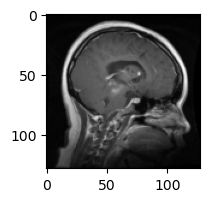

In [8]:
# pick a random image for testing out the CNN defined later
i = random.sample(range(len(train_set_orig)), 1)[0]
img, _ = train_set[i]
print(img.size()) # check size of image, making sure it's 128x128
# plotting
plt.figure(figsize = (2,2))
plt.imshow(img.permute(1, 2, 0), cmap = 'gray')

torch.Size([16, 1, 3, 3])
torch.Size([1, 128, 128])
torch.Size([128, 128])


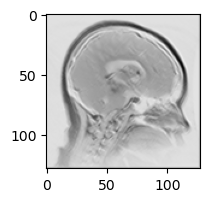

In [10]:
# Testing out the Convolution module
conv = nn.Conv2d(1, 16, kernel_size=3, padding=1)
print(conv.weight.size()) # checking the convolution size
print(img.size()) # print image size
output = conv(img.unsqueeze(0)) # applying convolution to image
print(output[0,0].detach().size()) # checking one of the output size
# plotting the effect of the first output by plotting
plt.figure(figsize = (2,2))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

This is where I defined the CNN, and training it

In [11]:
# This is the CNN definition
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # first layer
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1) # convolution
        self.act1 = nn.Tanh() # activation function
        self.pool1 = nn.MaxPool2d(2) # pooling to reduce size

        # second layer
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) # convolution 
        self.act2 = nn.Tanh() # activation function
        self.pool2 = nn.MaxPool2d(2) # pooling to reduce size

        # third layer
        self.fc1 = nn.Linear(8 * 32 * 32, 32)
        self.act3 = nn.Tanh()

        # making correct output
        self.fc2 = nn.Linear(32, 4) # 4 outputs for 3 different tumors and 1 non-tumar

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x))) # first layer
        out = self.pool2(self.act2(self.conv2(out))) # second layer
        out = out.view(-1, 8 * 32 * 32) # linearize 
        out = self.act3(self.fc1(out)) # last layer
        out = self.fc2(out) # making right output
        return out


In [12]:
# creating the CNN
model = Net()
# testing on the image
model(img.unsqueeze(0))

# counting the number of parameters
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(263628, [144, 16, 1152, 8, 262144, 32, 128, 4])

The training starts here:

In [13]:
import datetime

# the training loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch,loss_train / len(train_loader)))

In [218]:
model = Net() # CNN
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) # optimizer
loss_fn = nn.CrossEntropyLoss() # loss function
# training starts here
training_loop(n_epochs = 100, optimizer = optimizer, model = model, loss_fn = loss_fn, train_loader = train_loader)

2025-03-14 11:47:58.280496 Epoch 1, Training loss 1.1512672934267256
2025-03-14 11:51:30.580233 Epoch 10, Training loss 0.4119300529360771
2025-03-14 11:55:23.320946 Epoch 20, Training loss 0.2568037024802632
2025-03-14 11:59:19.592010 Epoch 30, Training loss 0.15950411794086297
2025-03-14 12:03:15.075752 Epoch 40, Training loss 0.10210805779529943
2025-03-14 12:07:11.067872 Epoch 50, Training loss 0.0668487388226721
2025-03-14 12:11:06.833329 Epoch 60, Training loss 0.0449526162714594
2025-03-14 12:15:03.451920 Epoch 70, Training loss 0.03167254672282272
2025-03-14 12:18:59.985820 Epoch 80, Training loss 0.023729799936215084
2025-03-14 12:22:57.509527 Epoch 90, Training loss 0.018304923885605402
2025-03-14 12:26:53.477355 Epoch 100, Training loss 0.01457814381768306


The validation is shown below, to check accuracy

In [221]:
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle = False) # validation set
train_loader2 = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle = False) # training set

# validation function
# I took this code from Depp Learning with PyTorch book
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [222]:
validate(model, train_loader2, val_loader) #running the validation

Accuracy train: 1.00
Accuracy val: 0.95
